In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sys.path.append('/raven/u/ajagadish/vanilla-llama/categorisation/')
sys.path.append('/raven/u/ajagadish/vanilla-llama/categorisation/rl2')
from baseline_classifiers import LogisticRegressionModel, SVMModel, benchmark_baseline_models_2d, benchmark_baseline_models_regex_parsed
import numpy as np

/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2021.11/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
COLORS = {'compositional':'#117733', 
          'noncompositional':'#96CAA7',
          'lr':'#88CCEE',#882255
          'svm':'#CC6677',
          'optimal': '#D6BF4D',
          'mean_tracker':'#882255', #332288
          'mean_tracker_compositional':'#882255', #AA4499',
          'rbf_nocontext_nomemory':'#44AA99', 
          'simple_grammar_constrained':'#44AA99',
          'simple_grammar_constrained_noncompositonal':'#EF9EBB',
          'rl2':'#E2C294', #'#0571D0', 
          'metal':'#DA9138', #"#D55E00", 
          }
FONTSIZE=20

## stats over many tasks



#### gpt-3

In [3]:
NUM_DATA=100

In [4]:
llama_gen_tasks = pd.read_csv('../data/gpt3_generated_tasks_paramsNA_dim3_data100_tasks130.csv')#temp/llama_generated_tasks_params65B_dim3_data8_tasks500_run0_procid0.csv')
llama_gen_tasks = llama_gen_tasks.query('target == "A" or target == "B"')
llama_gen_tasks = llama_gen_tasks[llama_gen_tasks.trial_id<NUM_DATA]
inputs = np.stack([eval(val)  for val in llama_gen_tasks.input.values])
targets = np.stack([val  for val in llama_gen_tasks.target.values])
num_tasks = llama_gen_tasks.task_id.max()+1
expected_number_points = np.array([llama_gen_tasks[llama_gen_tasks.task_id==ii].trial_id.max()+1 for ii in np.arange(num_tasks)]).mean()
llama=False

### score on n+1 point given fits on n point for gpt-3 dataset

In [5]:
from utils import evaluate_data_against_baselines
import torch

In [8]:
upto_trial=15
accuracy = evaluate_data_against_baselines(llama_gen_tasks, upto_trial)

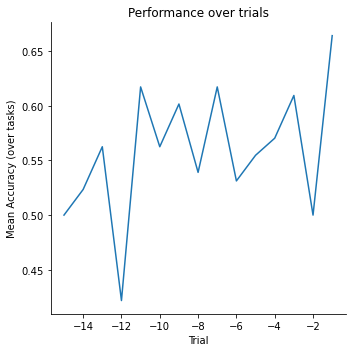

In [9]:
f, ax = plt.subplots(1, 1, figsize=(5,5))   
ax.plot(np.arange(-upto_trial,0), torch.stack(accuracy).sum(0)/(llama_gen_tasks.task_id.max()+1))
#ax.plot(llama_distances, label = 'llama')
ax.set_xlabel('Trial')
ax.set_ylabel('Mean Accuracy (over tasks)')
ax.set_title(f'Performance over trials')
#ax.legend()
sns.despine()
f.tight_layout()
plt.show()

### temporal auto-corrleation

In [6]:
from utils import l2_distance_trials_all

In [7]:
dds = []
random = True
assert random == False if llama else 'no need of random for llama'
shifts = 4 if llama else 86
within_targets = True
for shift in range(0, shifts):
    distances = l2_distance_trials_all(llama_gen_tasks, target='A', shift=shift, within_targets=within_targets, llama=llama, random=random)
    dds.append(distances)
nan_distances = np.nanmean(np.nanmean(np.stack(dds),1),1)

if llama:
    llama_distances = nan_distances
elif random:
    random_distances = nan_distances 
else:
    gpt3_distances = nan_distances

/tmp/ipykernel_66229/1818064910.py:9: RuntimeWarning: Mean of empty slice
  nan_distances = np.nanmean(np.nanmean(np.stack(dds),1),1)


have to run for all three types of data

NameError: name 'gpt3_distances' is not defined

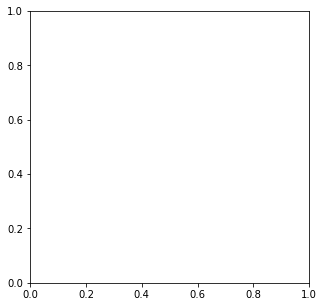

In [8]:
f, ax = plt.subplots(1, 1, figsize=(5,5))   
ax.plot(gpt3_distances, label='gpt3')
ax.plot(random_distances, label='samples from uniform dist')
#ax.plot(llama_distances, label = 'llama')
ax.set_xlabel('Trial')
ax.set_ylabel('L2 norm')
ax.set_title(f'Temporal Distances')
ax.legend()
sns.despine()
f.tight_layout()
plt.show()

### same category vs distance

In [ ]:
from utils import probability_same_target_vs_distance

In [ ]:
distances, probabilities = probability_same_target_vs_distance(llama_gen_tasks, random=True)

In [ ]:
dists, probs = np.nanmean(distances,0), np.nanmean(probabilities, 0)
# plot probability vs distance
f, ax = plt.subplots(1, 1, figsize=(7,7))
sns.regplot(dists, probs, ax=ax)
ax.set_title(f'Probability of same target vs distance between datapoints')
ax.set_xlabel('Distance between datapoints')
ax.set_ylabel('Probability of same target')
plt.show()

### autocorrelation of features

### step wise autocorrelations

In [22]:
from plots import l2_distance_trials

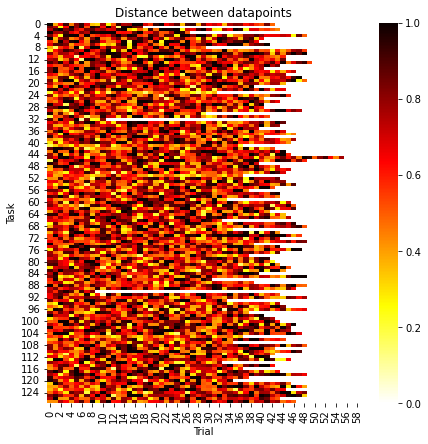

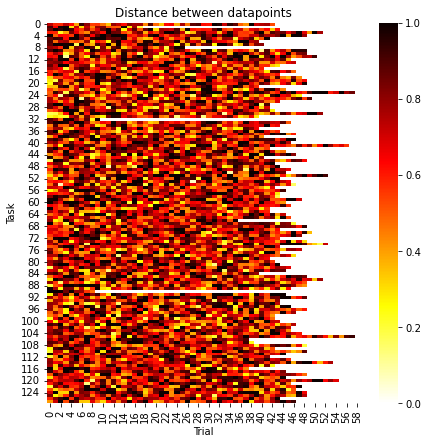

In [23]:
distances = l2_distance_trials(llama_gen_tasks, within_targets=True)

### per-task binning

In [73]:
def find_counts(inputs, dim, xx_min, xx_max):
    return (inputs[:, dim]<xx_max)*(inputs[:, dim]>xx_min)

#### random

#### llama 

### label imbalance issue

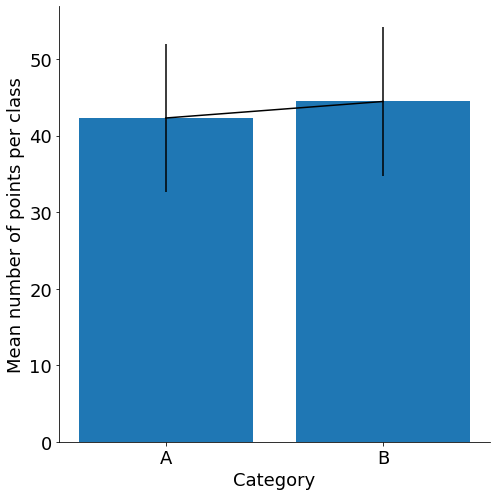

In [101]:
num_targets = np.stack([(llama_gen_tasks[llama_gen_tasks.task_id==task_id].target=='A').sum() for task_id in llama_gen_tasks.task_id.unique()])

f, ax = plt.subplots(1, 1, figsize=(7,7))

ax.bar(['A','B'], [num_targets.mean(), expected_number_points-num_targets.mean()])
ax.errorbar(['A','B'], [num_targets.mean(), expected_number_points-num_targets.mean()], yerr=[num_targets.std(), num_targets.std()], c='k')
#plt.legend(fontsize=FONTSIZE-5,  loc="upper center", bbox_to_anchor=(.45, 1.1), ncol=3, frameon=True)
ax.set_ylabel('Mean number of points per class', fontsize=FONTSIZE-2)
ax.set_xlabel('Category', fontsize=FONTSIZE-2) #$a_{name_trials}$
plt.xticks(fontsize=FONTSIZE-2)
plt.yticks(fontsize=FONTSIZE-2)
sns.despine()
f.tight_layout()
plt.show()

In [102]:
### choose inputs within the range 0 to 1
min_value = 0.
max_value = 1.
inputs_in_range = [(inputs[ii]>min_value).all() * (inputs[ii]<max_value).all() for ii in range(len(inputs))]
inputs = inputs[inputs_in_range]
targets = targets[inputs_in_range]

In [103]:
def find_counts(inputs, dim, xx_min, xx_max):
    return (inputs[:, dim]<xx_max)*(inputs[:, dim]>xx_min)

In [104]:
num_bins = 5
bins = np.linspace(0, 1, num_bins+1)[:-1]
bin_counts, target_counts = [], [] #np.zeros((len(bins)*3))
for ii in bins:
    x_min = ii 
    x_max = ii + 1/num_bins
    for jj in bins:
        y_min = jj
        y_max = jj + 1/num_bins
        for kk in bins:
            z_min = kk
            z_max = kk + 1/num_bins
            num_points = (find_counts(inputs, 0, x_min, x_max)*find_counts(inputs, 1, y_min, y_max)*find_counts(inputs, 2, z_min, z_max))
            bin_counts.append(num_points.sum())
            target_counts.append((targets[num_points]=='A').sum())

In [105]:
b_counts = np.stack(bin_counts)-np.stack(target_counts) 
a_counts = np.stack(target_counts) 

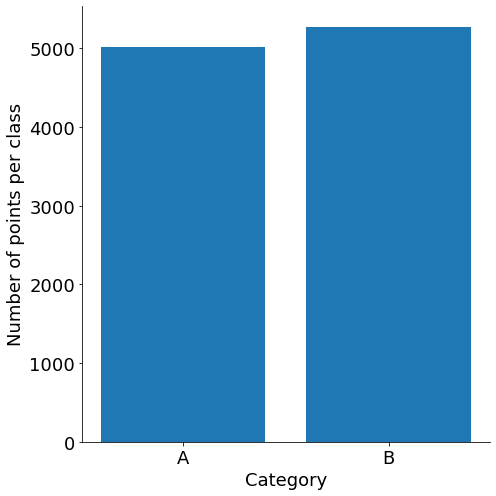

In [106]:
f, ax = plt.subplots(1, 1, figsize=(7,7))

ax.bar(['A','B'], [a_counts.sum(), b_counts.sum()])
#plt.legend(fontsize=FONTSIZE-5,  loc="upper center", bbox_to_anchor=(.45, 1.1), ncol=3, frameon=True)
ax.set_ylabel('Number of points per class', fontsize=FONTSIZE-2)
ax.set_xlabel('Category', fontsize=FONTSIZE-2) #$a_{name_trials}$
plt.xticks(fontsize=FONTSIZE-2)
plt.yticks(fontsize=FONTSIZE-2)
sns.despine()
f.tight_layout()
plt.show()

### binning points

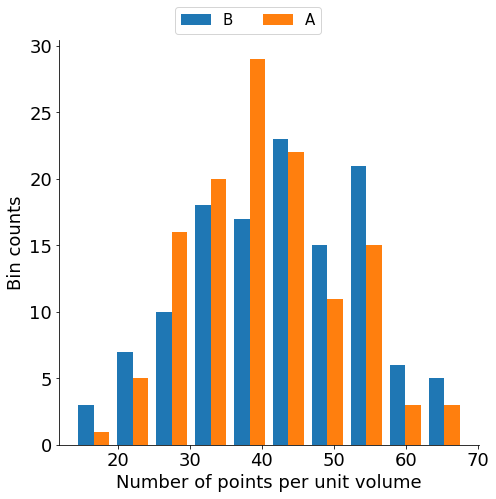

In [107]:
f, ax = plt.subplots(1, 1, figsize=(7,7))

ax.hist([b_counts, a_counts], label=['B', 'A'])
plt.legend(fontsize=FONTSIZE-5,  loc="upper center", bbox_to_anchor=(.45, 1.1), ncol=3, frameon=True)
ax.set_ylabel('Bin counts', fontsize=FONTSIZE-2)
ax.set_xlabel('Number of points per unit volume', fontsize=FONTSIZE-2) #$a_{name_trials}$
plt.xticks(fontsize=FONTSIZE-2)
plt.yticks(fontsize=FONTSIZE-2)
sns.despine()
f.tight_layout()
plt.show()

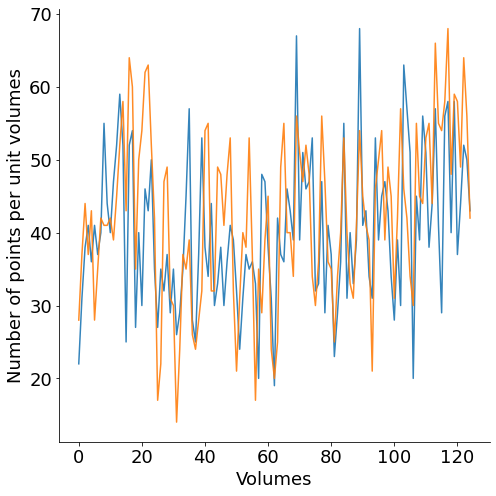

In [108]:
b_counts = np.stack(bin_counts)-np.stack(target_counts) 
a_counts = np.stack(target_counts) 
f, ax = plt.subplots(1, 1, figsize=(7,7))
ax.plot(np.arange(len(a_counts)), a_counts[::-1], alpha=0.9, label='A')
ax.plot(np.arange(len(b_counts)), b_counts[::-1], alpha=0.9, label='B')
ax.set_ylabel('Number of points per unit volumes', fontsize=FONTSIZE-2)
ax.set_xlabel('Volumes', fontsize=FONTSIZE-2) #$a_{name_trials}$
plt.xticks(fontsize=FONTSIZE-2)
plt.yticks(fontsize=FONTSIZE-2)
sns.despine()
f.tight_layout()
plt.show()


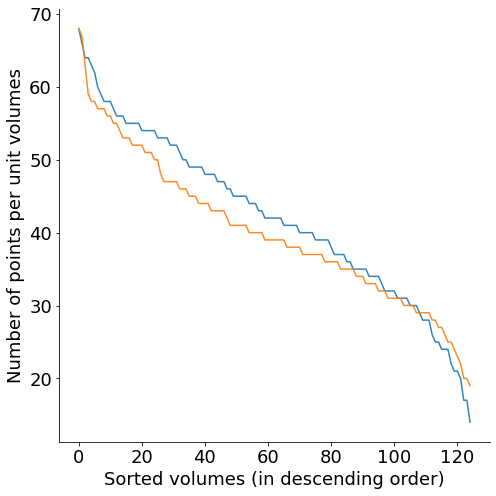

In [109]:
b_counts = np.stack(bin_counts)-np.stack(target_counts) 
a_counts = np.stack(target_counts) 
b_counts.sort()
a_counts.sort()

f, ax = plt.subplots(1, 1, figsize=(7,7))
ax.plot(np.arange(len(b_counts)), b_counts[::-1], alpha=0.9, label='B')
ax.plot(np.arange(len(a_counts)), a_counts[::-1], alpha=0.9, label='A')

ax.set_ylabel('Number of points per unit volumes', fontsize=FONTSIZE-2)
ax.set_xlabel('Sorted volumes (in descending order)', fontsize=FONTSIZE-2) #$a_{name_trials}$
plt.xticks(fontsize=FONTSIZE-2)
plt.yticks(fontsize=FONTSIZE-2)
sns.despine()
f.tight_layout()
plt.show()


In [ ]:
### scatters

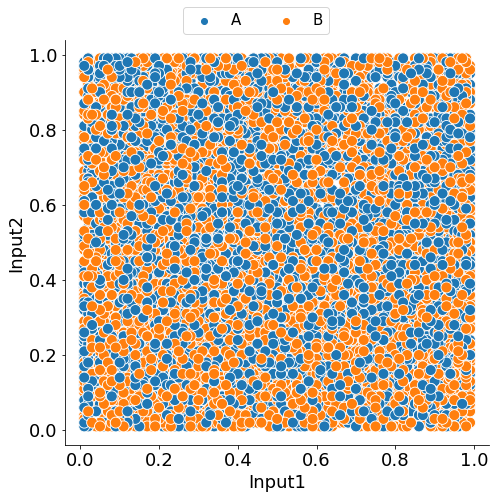

In [19]:
f, ax = plt.subplots(1, 1, figsize=(7,7))
sns.scatterplot(x=inputs[:,0], y=inputs[:,1], hue=targets,s=120)

plt.legend(fontsize=FONTSIZE-5,  loc="upper center", bbox_to_anchor=(.45, 1.1), ncol=3, frameon=True)
#plt.legend(loc='lower left', fontsize=FONTSIZE, frameon=True)
ax.set_xlabel('Input1', fontsize=FONTSIZE-2)
ax.set_ylabel('Input2', fontsize=FONTSIZE-2) #$a_{name_trials}$
#plt.xlim([0, 1.])
#plt.ylim([0, 1.])
plt.xticks(fontsize=FONTSIZE-2)
plt.yticks(fontsize=FONTSIZE-2)
sns.despine()
f.tight_layout()
plt.show()

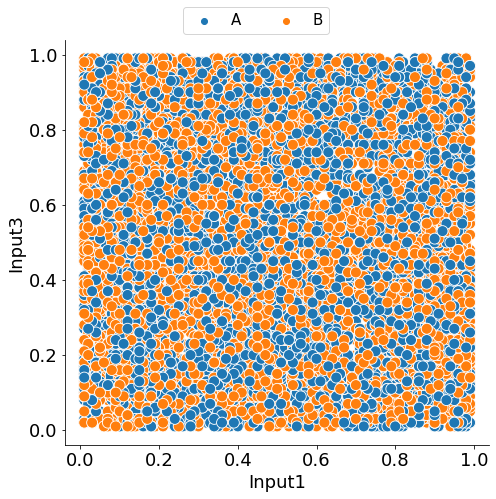

In [20]:
f, ax = plt.subplots(1, 1, figsize=(7,7))
sns.scatterplot(x=inputs[:,1], y=inputs[:,2], hue=targets,s=120)

plt.legend(fontsize=FONTSIZE-5,  loc="upper center", bbox_to_anchor=(.45, 1.1), ncol=3, frameon=True)
#plt.legend(loc='lower left', fontsize=FONTSIZE, frameon=True)
ax.set_xlabel('Input1', fontsize=FONTSIZE-2)
ax.set_ylabel('Input3', fontsize=FONTSIZE-2) #$a_{name_trials}$
# plt.xlim([0, 1.])
# plt.ylim([0, 1.])
plt.xticks(fontsize=FONTSIZE-2)
plt.yticks(fontsize=FONTSIZE-2)
sns.despine()
f.tight_layout()
plt.show()

### classifiablity

In [62]:
from utils import return_baseline_performance

In [67]:
random=True
means, std_errors, performance = return_baseline_performance(llama_gen_tasks, random=random)

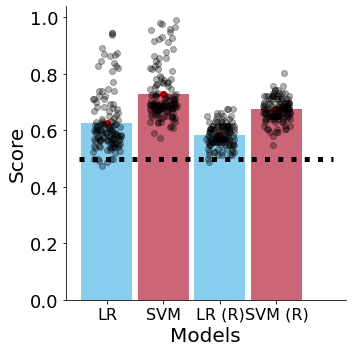

In [68]:
conditions =  ['LR', 'SVM', 'LR (R)', 'SVM (R)'] if random else ['LR', 'SVM']
colors =  [COLORS['lr'], COLORS['svm']] if random else [COLORS['lr'], COLORS['svm']]
FIGSIZE=(5,5)
f, ax = plt.subplots(1, 1, figsize=FIGSIZE)
## bar plot
ax.bar(np.arange(0,len(means)), means, color=colors, label=conditions, width=.9)
ax.errorbar(np.arange(0,len(means)), means, yerr=std_errors, color='r', lw=3, fmt='o') #linestyle='solid')

## plot individual points
w = 0.5
ax.hlines(0.5, -0.5, len(means), color='k', linestyles='dotted', lw=5)#, label='Random')
for i in range(len(means)):
    # distribute scatter randomly across whole width of bar
    ax.scatter(i + np.random.random(performance.shape[0]) * w - w / 2, performance[:, i], color='k', alpha=.3, zorder=3)

## formatting    
# ax.set_ylim(ymin=0., ymax=1.)

plt.xticks(np.arange(0,len(means)))
plt.yticks(fontsize=FONTSIZE-2)
ax.set_xlabel('Models', fontsize=FONTSIZE)
ax.set_ylabel(f'Score', fontsize=FONTSIZE)#$a_{trials}$
ax.set_xticklabels(conditions, fontsize=FONTSIZE-4)#['', '']
sns.despine()
f.tight_layout()
plt.show()

# Archive

## baseline model performance

In [47]:
data = pd.read_csv('data_tasks_7B.csv')
#data = pd.read_csv('data_tasks.csv')
num_tasks=10
performance = benchmark_baseline_models(num_tasks, data)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [48]:
performance

array([[0.54545455, 0.63636364],
       [0.8       , 0.8       ],
       [0.9       , 1.        ],
       [0.5       , 0.5       ],
       [0.8       , 0.8       ],
       [0.8       , 0.8       ],
       [0.6       , 1.        ],
       [0.57142857, 0.85714286],
       [0.66666667, 0.77777778],
       [0.5       , 0.5       ]])

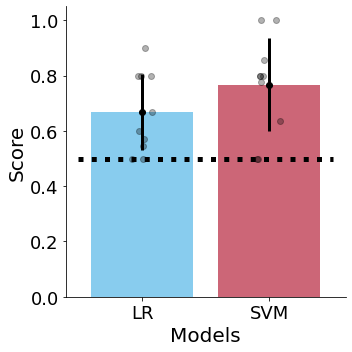

In [49]:
means = performance.mean(0)
std_errors = performance.std(0)#/np.sqrt(num_tasks-1)
conditions = ['LR', 'SVM']
colors = [COLORS['lr'], COLORS['svm']]
FIGSIZE=(5,5)

f, ax = plt.subplots(1, 1, figsize=FIGSIZE)
## bar plot
ax.bar(np.arange(0,2), means, color=colors, label=conditions)
ax.errorbar(np.arange(0,2), means, yerr=std_errors, color='k', lw=3, fmt='o') #linestyle='solid')

## plot individual points
w = 0.2
ax.hlines(0.5, -0.5, 1.5, color='k', linestyles='dotted', lw=5)#, label='Random')
for i in range(2):
    # distribute scatter randomly across whole width of bar
    ax.scatter(i + np.random.random(performance.shape[0]) * w - w / 2, performance[:, i], color='k', alpha=.3, zorder=3)

## formatting    
# ax.set_ylim(ymin=0., ymax=1.)
plt.xticks(np.arange(0,2))
plt.yticks(fontsize=FONTSIZE-2)
ax.set_xlabel('Models', fontsize=FONTSIZE)
ax.set_ylabel(f'Score', fontsize=FONTSIZE)#$a_{trials}$
ax.set_xticklabels(conditions, fontsize=FONTSIZE-2)#['', '']
sns.despine()
f.tight_layout()
plt.show()

## binary classifation

In [26]:
data = pd.read_csv('data_tasks.csv')

In [27]:
performance

array([[0.6, 1. ],
       [0.7, 0.7],
       [0.6, 0.7],
       [0.6, 0.7],
       [0.6, 0.9],
       [0.9, 1. ],
       [0.8, 0.7],
       [0.6, 0.6],
       [1. , 1. ],
       [0.6, 0.7]])

In [40]:
task_id=8
X = np.vstack([data[data.TaskID==task_id].Input1, data[data.TaskID==task_id].Input2]).T
y = data[data.TaskID==task_id].Target

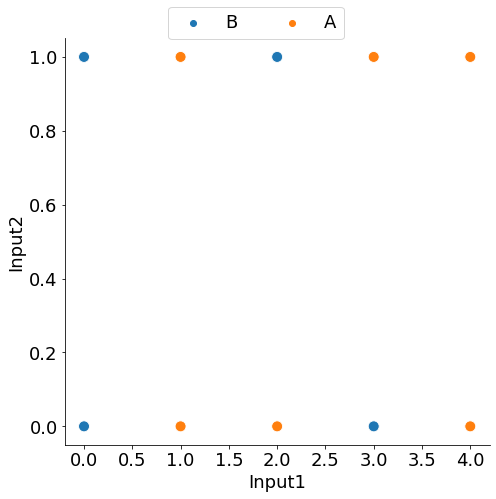

In [41]:
f, ax = plt.subplots(1, 1, figsize=(7,7))
sns.scatterplot(x=data[data.TaskID==task_id]['Input1'], y=data[data.TaskID==task_id]['Input2'], hue=data[data.TaskID==task_id]['Target'],s=120)

plt.legend(fontsize=FONTSIZE-2,  loc="upper center", bbox_to_anchor=(.45, 1.1), ncol=2, frameon=True)
#plt.legend(loc='lower left', fontsize=FONTSIZE, frameon=True)
ax.set_xlabel('Input1', fontsize=FONTSIZE-2)
ax.set_ylabel('Input2', fontsize=FONTSIZE-2) #$a_{name_trials}$
plt.xticks(fontsize=FONTSIZE-2)
plt.yticks(fontsize=FONTSIZE-2)
sns.despine()
f.tight_layout()
plt.show()

In [32]:
lr = LogisticRegressionModel(X, y)

In [33]:
lr.predict(X)

array(['A', 'A', 'B', 'B', 'B', 'A', 'B', 'B', 'A', 'A'], dtype=object)

In [34]:
lr.score(X, y)

0.6

## visualize tasks

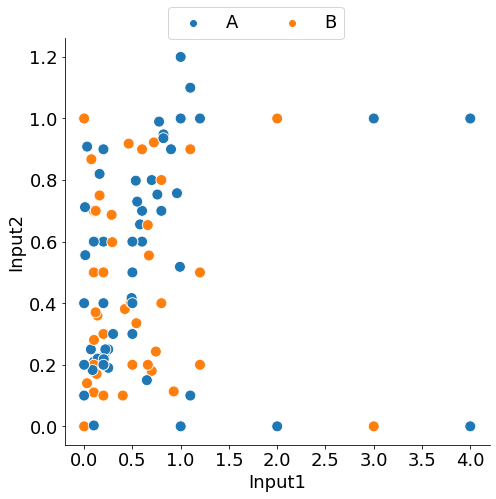

In [3]:
data = pd.read_csv('data_tasks.csv')
FONTSIZE=20
f, ax = plt.subplots(1, 1, figsize=(7,7))
sns.scatterplot(x=data['Input1'], y=data['Input2'], hue=data['Target'],s=120)

plt.legend(fontsize=FONTSIZE-2,  loc="upper center", bbox_to_anchor=(.45, 1.1), ncol=2, frameon=True)
#plt.legend(loc='lower left', fontsize=FONTSIZE, frameon=True)
ax.set_xlabel('Input1', fontsize=FONTSIZE-2)
ax.set_ylabel('Input2', fontsize=FONTSIZE-2) #$a_{name_trials}$
plt.xticks(fontsize=FONTSIZE-2)
plt.yticks(fontsize=FONTSIZE-2)
sns.despine()
f.tight_layout()
plt.show()

## visualize a task

In [4]:
task_id=4
data = pd.read_csv('data_tasks.csv')

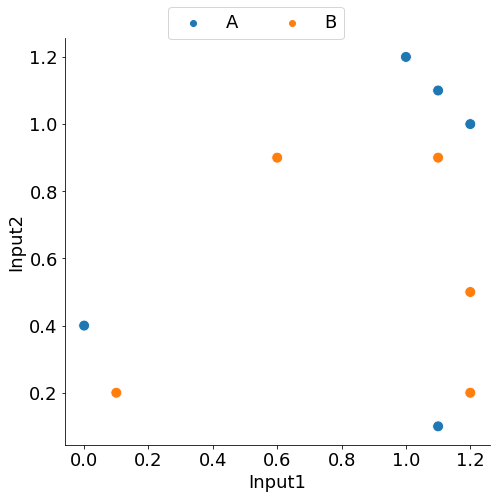

In [5]:
FONTSIZE=20
f, ax = plt.subplots(1, 1, figsize=(7,7))
sns.scatterplot(x=data[data.TaskID==task_id]['Input1'], y=data[data.TaskID==task_id]['Input2'], hue=data[data.TaskID==task_id]['Target'],s=120)

plt.legend(fontsize=FONTSIZE-2,  loc="upper center", bbox_to_anchor=(.45, 1.1), ncol=2, frameon=True)
#plt.legend(loc='lower left', fontsize=FONTSIZE, frameon=True)
ax.set_xlabel('Input1', fontsize=FONTSIZE-2)
ax.set_ylabel('Input2', fontsize=FONTSIZE-2) #$a_{name_trials}$
plt.xticks(fontsize=FONTSIZE-2)
plt.yticks(fontsize=FONTSIZE-2)
sns.despine()
f.tight_layout()
plt.show()

## example 2

In [2]:
data = pd.read_csv('data.csv')

In [4]:
data

,Input1,Input2,Target
0,0.23,0.89,A
1,0.21,0.15,A
2,0.66,0.97,A
3,0.79,0.40,B
4,0.48,0.87,B
5,0.64,0.69,B
6,0.04,0.35,B


<AxesSubplot:xlabel='Input1', ylabel='Input2'>

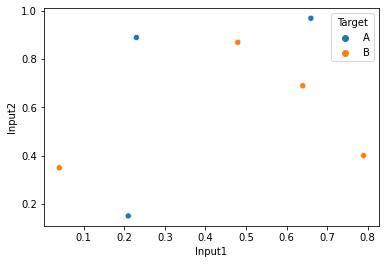

In [6]:
sns.scatterplot(x=data['Input1'], y=data['Input2'], hue=data['Target'])

## example 1

In [11]:
data = pd.read_csv('data.csv')
Bs = data[['B1', 'B2']]
As = data[['A1', 'A1']]

<AxesSubplot:xlabel='B1', ylabel='B2'>

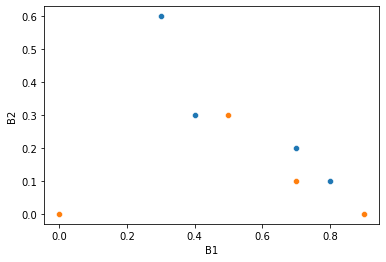

In [19]:
sns.scatterplot(x=data['B1'], y=data['B2'])
sns.scatterplot(x=data['A1'], y=data['A2'])